# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
  - The client wants to have a ML model so that we can use it to test their HIP software.

## Inputs

* inputs/cats_vs_dogs_dataset/train
* inputs/cats_vs_dogs_dataset/validation
* inputs/cats_vs_dogs_dataset/test
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Machine learning model creation and training.
* Learning curve plot for model performance.
* Model evaluation on pickle file.

## Additional Comments

* 


---

# **Preparation setup**

## Import libraries

In [1]:
%pip install -r /workspace/pp5-cats-vs-dogs/requirements.txt 2>/dev/null | grep -v 'Requirement already satisfied'
print('Requirements installed.')

Note: you may need to restart the kernel to use updated packages.
Requirements installed.


In [2]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Set working directory

Set working directory to root project folder

In [3]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
root_dir = os.getcwd()
print('New folder: ' + root_dir)

Current folder: /workspace/pp5-cats-vs-dogs/jupyter_notebooks
New folder: /workspace/pp5-cats-vs-dogs


## Set input directories

In [4]:
dataset_folder = 'inputs/cats_vs_dogs_dataset_small'
train_path = dataset_folder + '/train'
validation_path = dataset_folder + '/validation'
test_path = dataset_folder + '/test'
train_path

'inputs/cats_vs_dogs_dataset_small/train'

## Set output directory

In [5]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(root_dir) and version in os.listdir(root_dir + '/outputs'):
    print(f'Version {version} is already available.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'New directory for version {version} has been created')

New directory for version v3 has been created


## Set label names

In [6]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['cat', 'dog']


## Set image shape

In [22]:
version = 'v2'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(180, 202, 3)

## Number of images in dataset

* train - cat: 1750 images
* train - dog: 1750 images
* validation - cat: 250 images
* validation - dog: 250 images
* test - cat: 500 images
* test - dog: 500 images




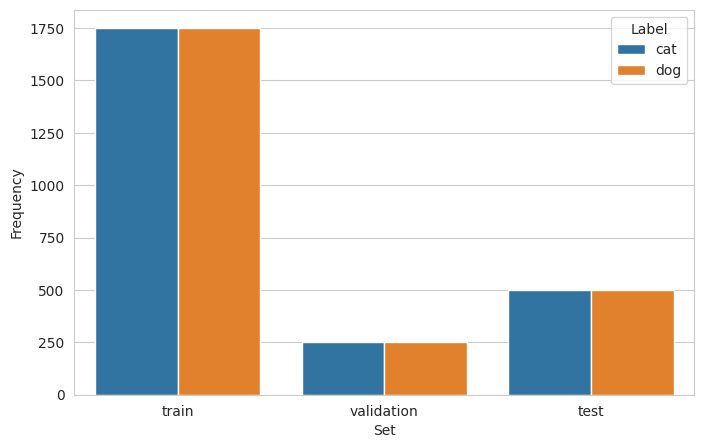

In [8]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        new_row = pd.DataFrame({
            'Set': [folder],
            'Label': [label],
            'Frequency': [len(os.listdir(dataset_folder + '/' + folder + '/' + label))]
        })
        df_freq = pd.concat([df_freq, new_row], ignore_index=True)

        print(
            f"* {folder} - {label}: {len(os.listdir(dataset_folder +'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image data generator

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20

train_set = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

print(train_set.class_indices)

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

print(validation_set.class_indices)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

print(test_set.class_indices)

Found 3500 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Found 500 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Found 1000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}


---

# **Model creation**

## ML model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',                
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Summary

In [25]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 178, 200, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 100, 16)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 98, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 49, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 23, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14720)            

### Early stopping

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for training

In [26]:
model = create_tf_model()
model.fit(train_set,
          epochs=10,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/10
175/175 [==============================] - 25s 140ms/step - loss: 0.7462 - accuracy: 0.4669 - val_loss: 0.6922 - val_accuracy: 0.5820
Epoch 2/10
175/175 [==============================] - 21s 118ms/step - loss: 0.6943 - accuracy: 0.5186 - val_loss: 0.6878 - val_accuracy: 0.6060
Epoch 3/10
175/175 [==============================] - 20s 114ms/step - loss: 0.7539 - accuracy: 0.5306 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 4/10
175/175 [==============================] - 20s 113ms/step - loss: 0.6929 - accuracy: 0.5034 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 5/10
175/175 [==============================] - 20s 115ms/step - loss: 0.6832 - accuracy: 0.5351 - val_loss: 0.6788 - val_accuracy: 0.6160
Epoch 6/10
175/175 [==============================] - 20s 114ms/step - loss: 0.6797 - accuracy: 0.6009 - val_loss: 0.6737 - val_accuracy: 0.6020
Epoch 7/10
175/175 [==============================] - 20s 114ms/step - loss: 0.6422 - accuracy: 0.6377 - val_loss: 0.6400 - val_ac

### Save the model

In [27]:
model.save(f'{file_path}/cats_vs_dogs_model.h5')

---
## Model performance

### Model learning curve

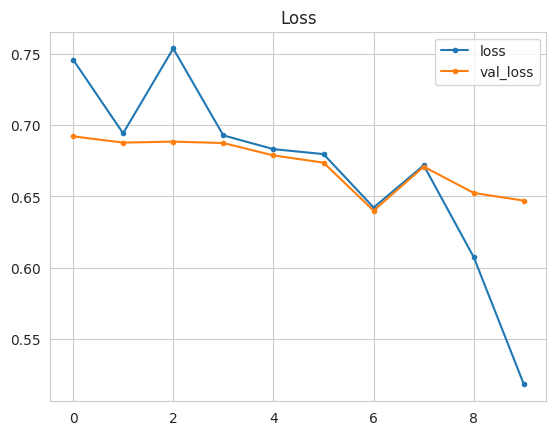

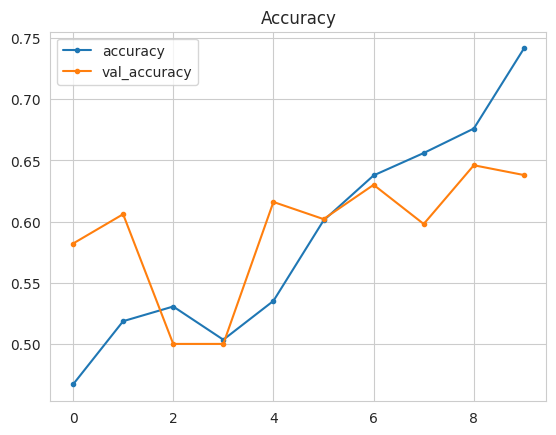

In [28]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

#### Load model

In [29]:
from keras.models import load_model
model = load_model(f'{file_path}/cats_vs_dogs_model.h5')

#### Evaluate on the test set

In [31]:
evaluation = model.evaluate(test_set)

 1/50 [..............................] - ETA: 3s - loss: 1.1788 - accuracy: 0.3000

50/50 [==============================] - 2s 34ms/step - loss: 0.6775 - accuracy: 0.6520


#### Save evaluation

In [32]:
joblib.dump(value=evaluation,
            filename=f'{file_path}/evaluation.pkl')

['outputs/v3/evaluation.pkl']

### Predict on new data

#### Load random image as PIL

Image shape: (202, 180), Image mode: RGB


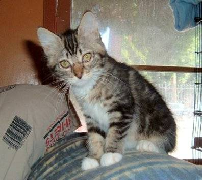

In [33]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array

In [34]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 180, 202, 3)


#### Predict class on the image

In [35]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9134869426488876
cat


---
# Push files to Repo

Check changed files:

In [ ]:
!git status

Add, commit and push to repo (all files or individual file)

In [ ]:
!git add .

!git commit -m "Message"

!git push

# Conclusions

Model v1
- 0,7986 acc, 62 min to fit
- Conv2D -> filters= 32 -> 64 -> 64 = 16,9 mil params
- Modelsize 388 mb - deleted

New v1
- 0,9223 acc, 19 min to fit
- Conv2D -> filters= 16 -> 32 -> 32 = 8,4 mil params
- Modelsize 97 mb - saved and pushed to github

**Nr of params affect modelsize.**

New v1 with evaluation
- 0.8254, 43 min to fit (slow gitpod workspace)
- Conv2D -> filters= 16 -> 32 -> 32 = 8,4 mil params
- Modelsize 97 mb - saved and pushed to github


V2 
- Used softmax instead of sigmoid
- loss: 1.0727 - accuracy: 0.6230 on test set
- 16 min to train

V3
- Reduced image size to 25% of average
- loss: 0.7066 - accuracy: 0.5120
- 22 seconds to train

New V3
- reduced image size to 50% of average
- loss: 0.6775 - accuracy: 0.6520
- 3 min 25 sec to train
- modelsize = 22 mb
